# Google Landmark 2019

References:
4th place solution last year
https://www.kaggle.com/c/landmark-recognition-challenge/discussion/57896#latest-418704

Compressed and resized training and test images
https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770#latest-532165

https://www.kaggle.com/c/landmark-recognition-2019/discussion/90346#latest-532193

EDA and loading data
https://www.kaggle.com/mayukh18/dataset-exploration-and-simple-on-the-fly-training



Plan

1. bring in training images that have >K examples for each class.  K=10
2. Train resnet34 on this and see xval score (basic classification)
3. Understand how to measure the metric being optimized in the contest
4. develop a heuristic/trained approach for submitting results

**Need to randomize the training data order - seems to be ordered by # of examples in each class

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import torch


In [3]:
from smtplib import SMTP_SSL as SMTP
from email.mime.text import MIMEText
def send_txt(subject, body, toaddr="6519834115@tmomail.net"):
    fromaddr = "thebignotifier@gmail.com"
    msg = MIMEText(body, 'plain')
    msg['To'] = toaddr
    msg['Subject'] = subject

    server = SMTP('smtp.gmail.com')
    server.login(fromaddr, "eatbzltjueqfdopg")
    server.sendmail(fromaddr, toaddr, msg.as_string())
    server.quit()

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 100
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [ ]:
Path()

In [5]:
path=Path("/media/SSD/data_google_landmark_recog_2019")
path.ls()

[PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/recognition_sample_submission.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256.tar'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission3.1.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/data_import.sh'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission1.1.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split1.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission3.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split2.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test-256'),
 PosixPath('/media/SSD/data_googl

In [6]:
path_img = path / 'train-256'
path_img

PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256')

## Looking at the data

In [7]:
train = pd.read_csv(path / "train.csv")
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))


                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  
(4132914, 3)
Number of classes 203094


In [8]:
files = os.listdir(path_img)

In [9]:
#get all the files in the image directory and drop the ''.jpg' of the filename to get the 'id' of the image
def clean_string (x):
    return x[:-4]

#lst = set(map(clean_string,os.listdir(path_img)))
lst = set([clean_string(x) for x in files if '.jpg' in x])

In [10]:
# select image ids that have image files
lst3 = [value[0] for value in zip(train.index, train['id']) if value[1] in lst]
train2=train.loc[lst3]

In [11]:
K=100
counts = dict(Counter(train2['landmark_id']))
landmarks_dict = {x:[] for x in train2.landmark_id.unique() if (counts[x] >= K)}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

Total number of valid classes: 6513


In [12]:
new_train = train2[train2['landmark_id'].isin(landmarks_dict)].copy()
print(new_train.head())
print(new_train.shape)
print("Number of classes {}".format(len(new_train.landmark_id.unique())))

                  id                                                url  \
1   202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
4   4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   
6   6f31b874d1a4d489  https://upload.wikimedia.org/wikipedia/commons...   
9   8df019949b8db328  https://upload.wikimedia.org/wikipedia/commons...   
11  ccf070a2da242d56  https://upload.wikimedia.org/wikipedia/commons...   

    landmark_id  
1        104169  
4          2474  
6          6888  
9         81049  
11       138982  
(1263760, 3)
Number of classes 6513


In [13]:
del train2,train, lst, files, lst3, counts, landmarks_dict

In [14]:
learn=None
gc.collect()
torch.cuda.empty_cache()

In [15]:
#data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs, num_workers=5).normalize(imagenet_stats)


In [ ]:
data.show_batch(rows=3, figsize=(6,6))

## Training: resnet50

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [16]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate).to_fp16()
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [26]:
learn.load('res50-stage-5');

In [27]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(0,1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,2.545115,2.001509,0.304013,1:07:17
1,2.499792,2.008250,0.304690,1:07:10
2,2.512232,2.022694,0.305766,1:07:12
3,2.493040,2.027084,0.306000,1:07:11
4,2.521382,2.016701,0.305865,1:07:11


In [28]:
learn.save('res50-stage-6')

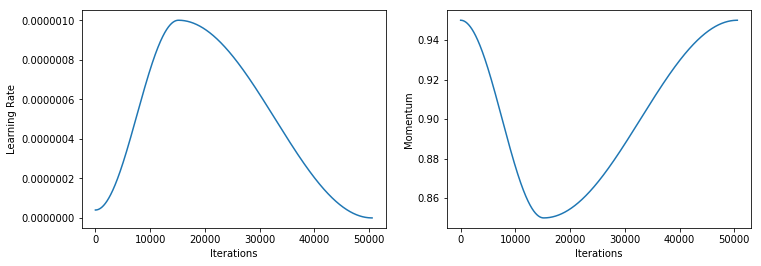

In [29]:
learn.recorder.plot_lr(show_moms=True)

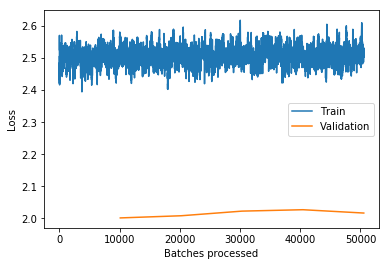

In [30]:
learn.recorder.plot_losses()

Min numerical gradient: 4.00E-08


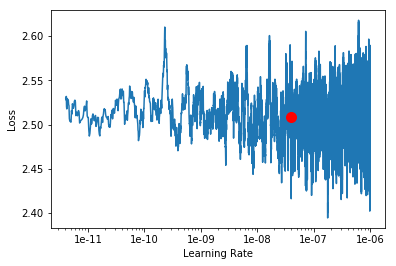

In [31]:
learn.recorder.plot(suggestion=True)

In [32]:
send_txt("!!","stage6 complete")

# Predict test set

In [33]:
#export model and other contains everything we need to deploy our model 
#(the model, the weights but also some metadata like the classes or the transforms/normalization used).
learn.export("export.pkl")

#to load it
#learn = load_learner(path)


In [34]:
# path to test set
path_test = path / 'test_256-2/test'
path_test

PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2/test')

In [35]:
# load submission
submission = pd.read_csv(path / 'recognition_sample_submission.csv', index_col='id')


In [39]:
# predict test set
#from fastprogress import master_bar, progress_bar

for fn in progress_bar(submission.index):
    try:
        img = open_image(path_test / (fn + '.jpg'))
    except:
        #print("file not found:"+ fn + '.jpg')
        submission.loc[fn]=""
    else:
        pred_class,pred_idx,outputs = learn.predict(img)
        #print(pred_class, pred_idx,outputs[pred_idx])
        submission.loc[fn]=str(pred_class)+ " "+ str(outputs[pred_idx].item())
submission[0:20]
    

,landmarks
id,
cc4e1335111d0f14,151942 0.8046962022781372
75f7113a26d670d9,142343 0.7453129887580872
3eeb10b0aa3cfbff,86869 0.13440503180027008
cefe5f969b9d4324,49267 0.5479543805122375
9324ef326508dda3,101399 0.004691441077739
fa8a341223e53b45,120885 0.12741638720035553
a0b3a793f1b8e5c1,80177 0.21484023332595825
a4bbe52b528c33a4,67416 0.03654484450817108
7ab6befcb914f4f0,126061 0.0433906614780426


In [40]:
submission.to_csv(path / 'submission4.csv',index=True)

In [41]:
send_txt("!!","test submission 4 complete")

https://www.kaggle.com/c/landmark-recognition-2019/discussion/89903#latest-530343

Hello everyone,
in train data Landmark with Id = 138982 has 10247 images. I looked at some of them and found that they are from rather different places.
So i think that images with this Landmark_Id are not associated with any real landmark. 

In [ ]:
#blank out the results to indicate no mandmarl for this id
submission.loc[submission['landmarks'].str.contains('138982 '), 'landmarks'] = ""

In [ ]:
submission.to_csv(path / 'submission4.1.csv',index=True)

In [ ]:
send_txt("!!","test submission 4.1 complete")